In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             median_absolute_error, explained_variance_score,
                             mean_squared_log_error)

# Better graph styles
plt.style.use('ggplot')

In [10]:
# Load the data
file_path = 'Steel_industry_data.csv'
steel_data = pd.read_csv(file_path)

# Preprocessing
steel_data['date'] = pd.to_datetime(steel_data['date'])
steel_data['hour'] = steel_data['date'].dt.hour
steel_data['day'] = steel_data['date'].dt.day
steel_data['month'] = steel_data['date'].dt.month
steel_data['year'] = steel_data['date'].dt.year
steel_data['dayofweek'] = steel_data['date'].dt.dayofweek
steel_data.drop('date', axis=1, inplace=True)
categorical_columns = ['WeekStatus', 'Day_of_week', 'Load_Type']
steel_data_encoded = pd.get_dummies(steel_data, columns=categorical_columns, drop_first=True)

steel_data_encoded.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,hour,day,month,...,dayofweek,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Maximum_Load,Load_Type_Medium_Load
0,3.17,2.95,0.0,0.0,73.21,100.0,900,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,0,1,1,...,0,0,1,0,0,0,0,0,0,0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,0,1,1,...,0,0,1,0,0,0,0,0,0,0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,1,1,1,...,0,0,1,0,0,0,0,0,0,0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,1,1,1,...,0,0,1,0,0,0,0,0,0,0


In [11]:
continuous_features = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh']

In [12]:
# Define categorical variables for one-hot encoding
categorical_columns = ['WeekStatus', 'Day_of_week', 'Load_Type']

# One-hot encoding of categorical variables
onehot_encoder = OneHotEncoder()
encoded_categorical = onehot_encoder.fit_transform(steel_data[categorical_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical.toarray(),
                                      columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Drop the original categorical columns and concatenate the one-hot encoded columns
steel_data = pd.concat([steel_data.drop(categorical_columns, axis=1), encoded_categorical_df], axis=1)

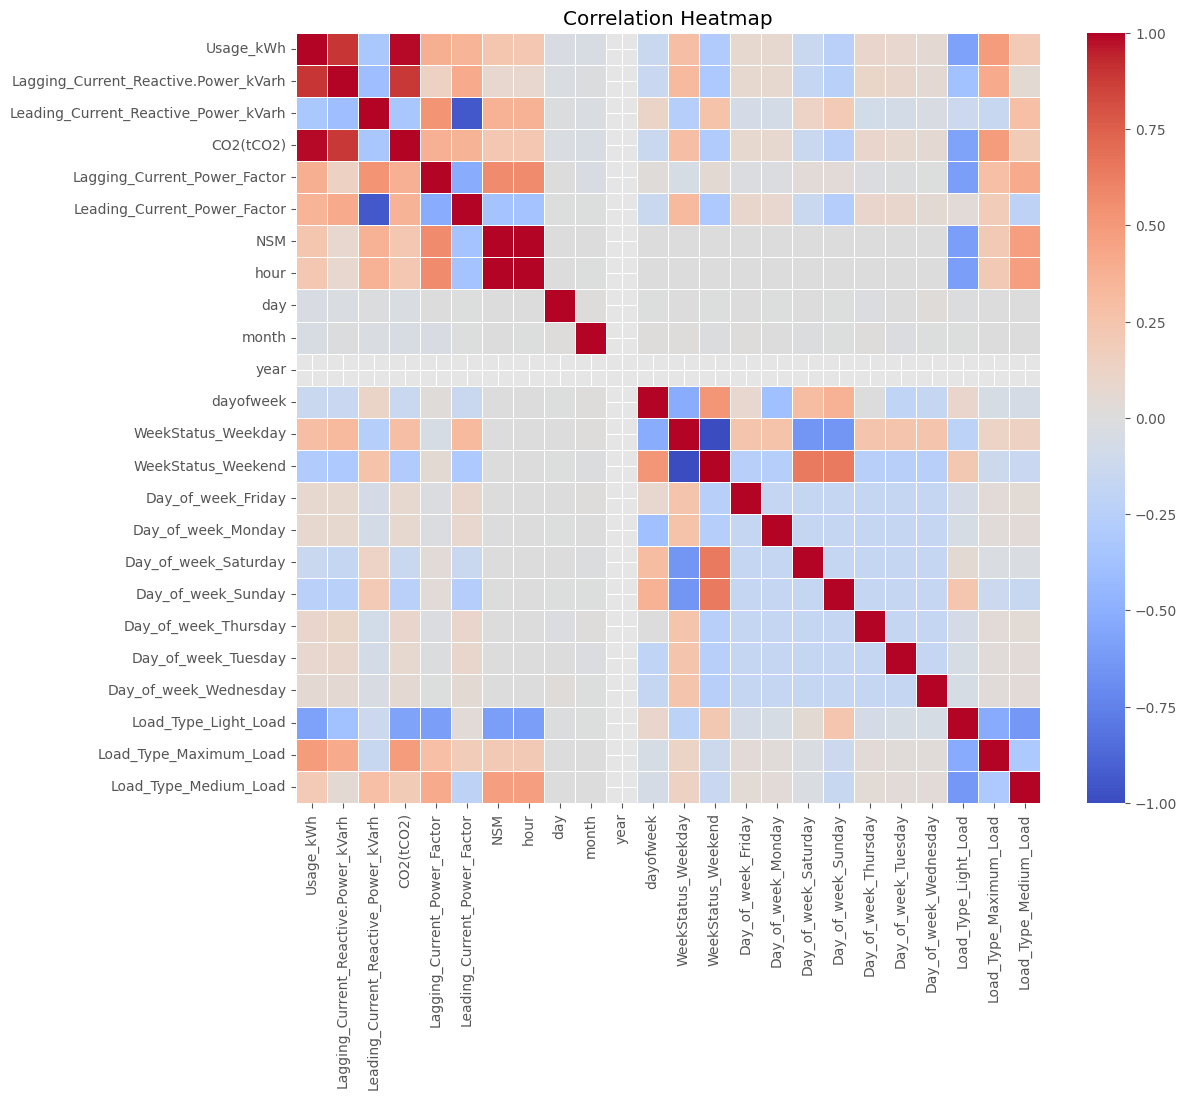

In [13]:
# Calculate the correlation matrix
correlation_matrix = steel_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Select features based on correlation threshold
selected_features = correlation_matrix['Usage_kWh'].abs() > 0.2
selected_features = selected_features[selected_features].index.drop('Usage_kWh')

In [14]:
# Define your features and target variable using the selected features
X = steel_data[selected_features]
y = steel_data['Usage_kWh']

In [16]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Create an SVR pipeline with feature scaling and training
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))  # Use SVR with a non-linear kernel for regression
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

In [18]:
# Define the cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get the cross-validated metric scores
scores = cross_val_score(pipeline, X, y, cv=cv_strategy, scoring='neg_mean_squared_error')

# Output the mean and standard deviation of the CV scores
print(f"Mean CV Score: {-scores.mean()}")
print(f"Standard Deviation of CV Score: {scores.std()}")


Mean CV Score: 10.871222375191381
Standard Deviation of CV Score: 1.5546417999596667


In [19]:
print(f"Scores: {scores}")

Scores: [ -9.69076612  -9.01176824 -10.64912056 -11.53687416 -13.4675828 ]


In [ ]:
# Define the parameter grid for SVR
param_grid = {
    'svr__C': [0.1, 1, 10, 100],  # Example C values
    'svr__gamma': ['scale', 'auto'],  # Example gamma values
    'svr__kernel': ['rbf', 'linear']  # Example kernel types
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Extract the best parameters, best model, and evaluate it
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Output best parameters
print("Best Parameters for SVR:", best_params)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best Parameters for SVR: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [ ]:
# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

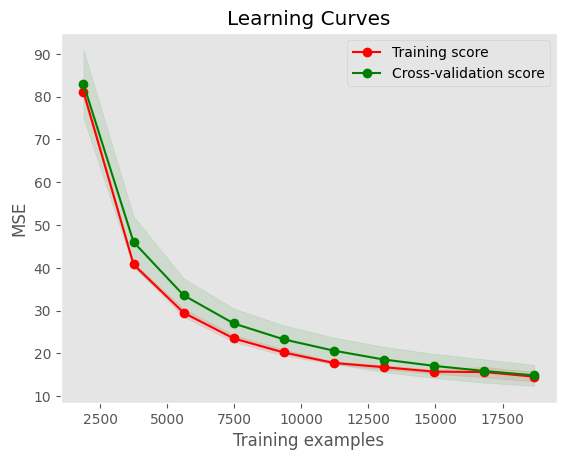

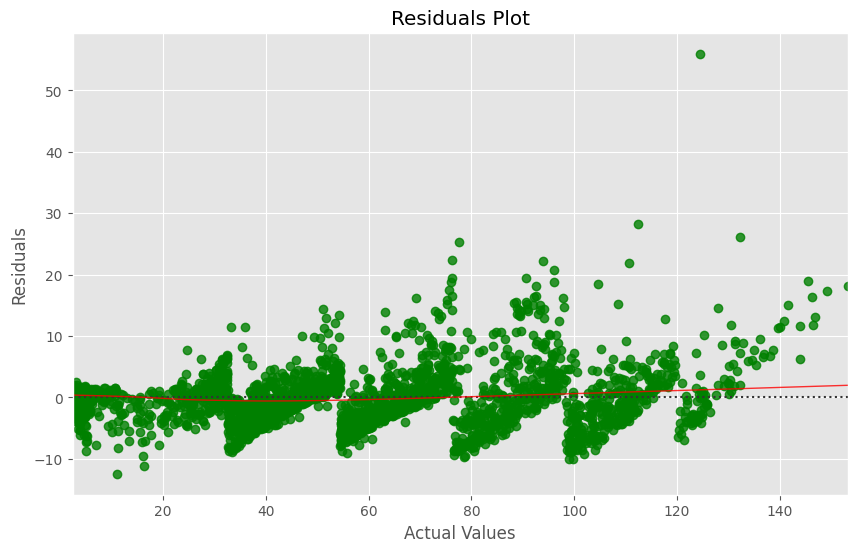

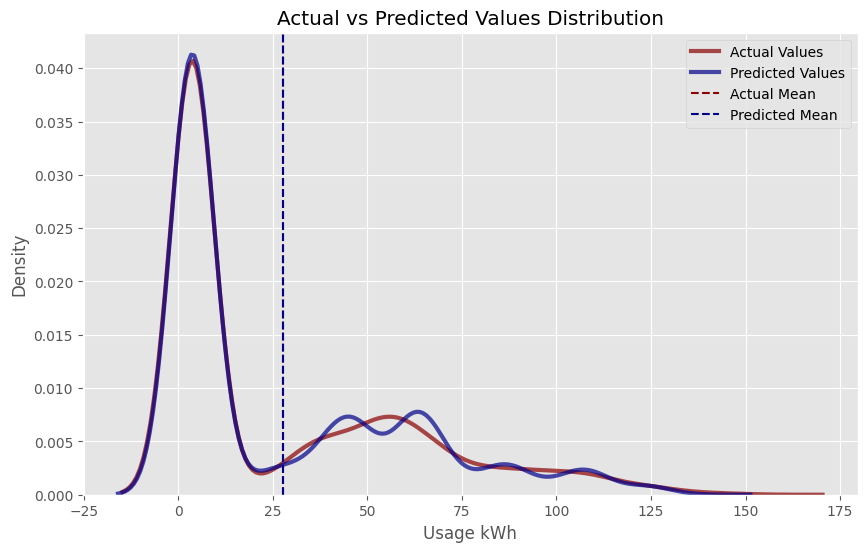

In [ ]:
#LOSS Curves

# Function to plot the learning curves
def plot_learning_curves(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring='neg_mean_squared_error')

    # Mean and standard deviation of training scores
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)

    # Mean and standard deviation of validation scores
    validation_scores_mean = -validation_scores.mean(axis=1)
    validation_scores_std = validation_scores.std(axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.grid()

    # Plot the average training and validation scores with standard deviation area
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Apply the function to your pipeline
plot_learning_curves(pipeline, X_train, y_train, cv=3)

residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=residuals, lowess=True, color="g", line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10, 6))

# Plot the KDE for actual values
sns.kdeplot(y_test, color='darkred', label='Actual Values', alpha=0.7, lw=3)

# Plot the KDE for predicted values
sns.kdeplot(y_test_pred, color='darkblue', label='Predicted Values', alpha=0.7, lw=3)

# Add vertical lines for the mean of the actual and predicted values
plt.axvline(y_test.mean(), color='darkred', linestyle='--', label='Actual Mean')
plt.axvline(y_test_pred.mean(), color='darkblue', linestyle='--', label='Predicted Mean')

plt.title('Actual vs Predicted Values Distribution')
plt.xlabel('Usage kWh')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# Calculate the performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_med_ae = median_absolute_error(y_train, y_train_pred)
test_med_ae = median_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_explained_var = explained_variance_score(y_train, y_train_pred)
test_explained_var = explained_variance_score(y_test, y_test_pred)

# Adjusted R-squared calculation
n_train = X_train.shape[0]
p_train = X_train.shape[1]
train_adjusted_r2 = 1 - (1 - train_r2) * ((n_train - 1) / (n_train - p_train - 1))

n_test = X_test.shape[0]
p_test = X_test.shape[1]
test_adjusted_r2 = 1 - (1 - test_r2) * ((n_test - 1) / (n_test - p_test - 1))

# MSLE and RMSLE require non-negative target values
# Add a small constant to avoid taking log of zero
epsilon = 1e-10
train_msle = mean_squared_log_error(y_train + epsilon, y_train_pred + epsilon)
test_msle = mean_squared_log_error(y_test + epsilon, y_test_pred + epsilon)
train_rmsle = np.sqrt(train_msle)
test_rmsle = np.sqrt(test_msle)

# MAPE calculation (note: handle division by zero if y_train or y_test contains zero values)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

In [ ]:
# Output the performance metrics
performance_metrics = {
    'Train MSE': train_mse,
    'Test MSE': test_mse,
    'Train RMSE': train_rmse,
    'Test RMSE': test_rmse,
    'Train MAE': train_mae,
    'Test MAE': test_mae,
    'Train Median AE': train_med_ae,
    'Test Median AE': test_med_ae,
    'Train R2': train_r2,
    'Test R2': test_r2,
    'Train Adjusted R2': train_adjusted_r2,
    'Test Adjusted R2': test_adjusted_r2,
    'Train Explained Variance': train_explained_var,
    'Test Explained Variance': test_explained_var,
    'Train MSLE': train_msle,
    'Test MSLE': test_msle,
    'Train RMSLE': train_rmsle,
    'Test RMSLE': test_rmsle,
    'Train MAPE': train_mape,
    'Test MAPE': test_mape
}

# Printing out the metrics
for metric_name, metric_value in performance_metrics.items():
    print(f'{metric_name}: {metric_value:.4f}')


Train MSE: 10.9091
Test MSE: 9.6909
Train RMSE: 3.3029
Test RMSE: 3.1130
Train MAE: 1.5090
Test MAE: 1.4976
Train Median AE: 0.2360
Test Median AE: 0.2565
Train R2: 0.9902
Test R2: 0.9915
Train Adjusted R2: 0.9902
Test Adjusted R2: 0.9915
Train Explained Variance: 0.9903
Test Explained Variance: 0.9915
Train MSLE: 0.0074
Test MSLE: 0.0077
Train RMSLE: 0.0858
Test RMSLE: 0.0879
Train MAPE: 5.6506
Test MAPE: 5.9138


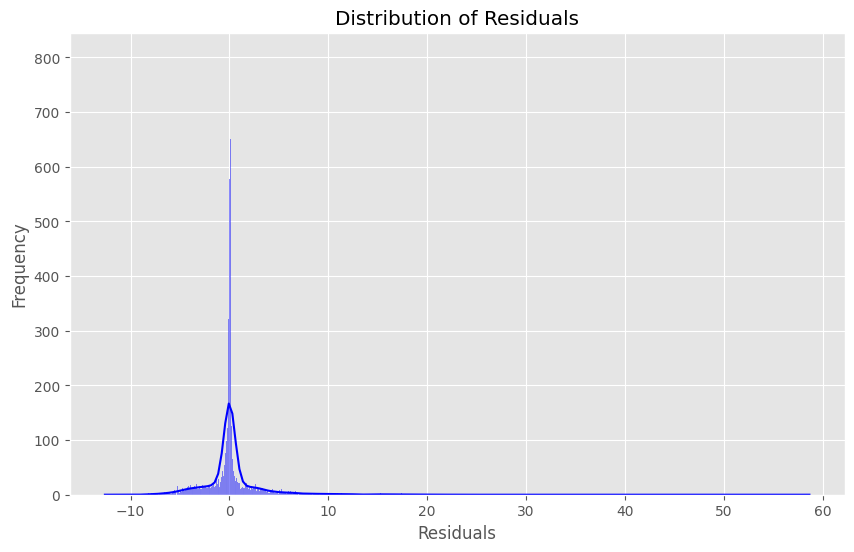

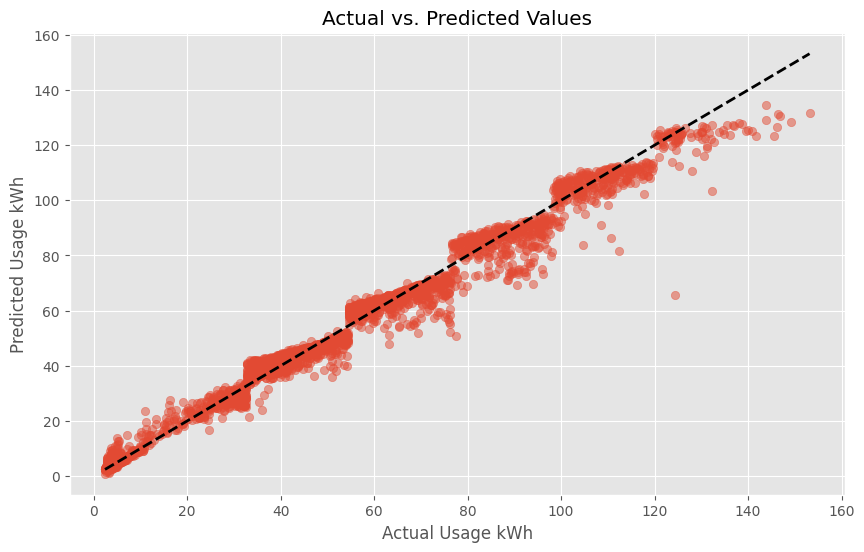

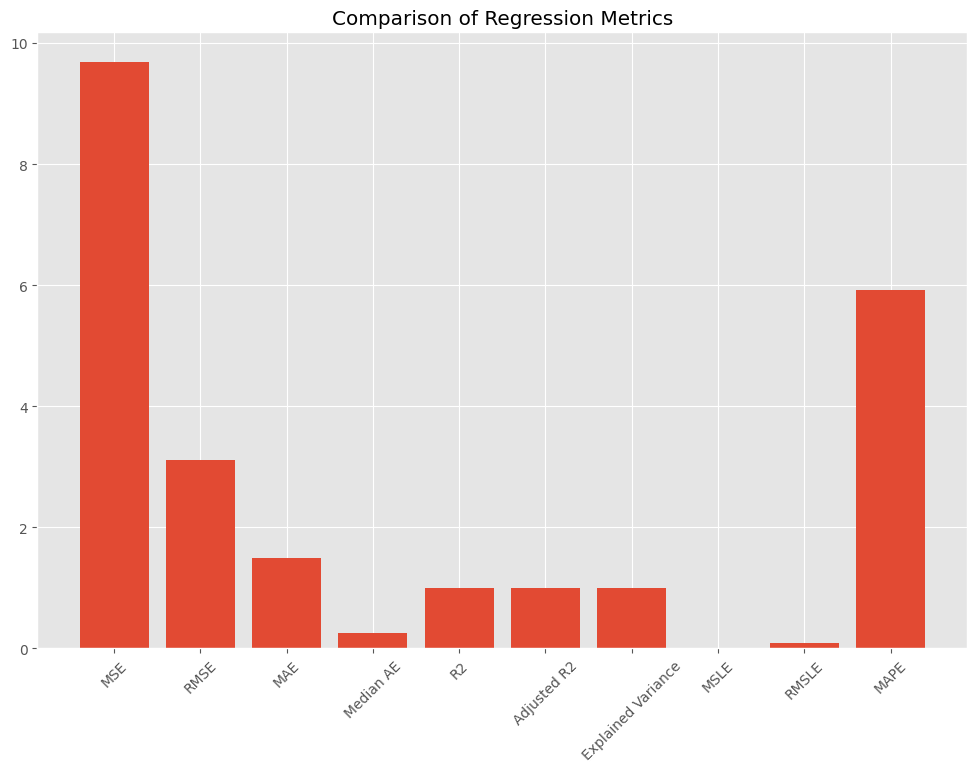

In [ ]:
# Assuming error metrics have been calculated and are stored in respective variables

# Visualize the distribution of errors (residuals)
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Usage kWh')
plt.ylabel('Predicted Usage kWh')
plt.show()

# Bar plot for scalar metrics
scalar_metrics = {
    'MSE': test_mse,
    'RMSE': test_rmse,
    'MAE': test_mae,
    'Median AE': test_med_ae,
    'R2': test_r2,
    'Adjusted R2': test_adjusted_r2,
    'Explained Variance': test_explained_var,
    'MSLE': test_msle,
    'RMSLE': test_rmsle,
    'MAPE': test_mape
}

plt.figure(figsize=(12, 8))
plt.bar(range(len(scalar_metrics)), list(scalar_metrics.values()), align='center')
plt.xticks(range(len(scalar_metrics)), list(scalar_metrics.keys()), rotation=45)
plt.title('Comparison of Regression Metrics')
plt.show()